<a href="https://colab.research.google.com/github/maramsumanth/AI-Driving-Car/blob/master/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def convert_to_iso(date_col):
    """
    Convert a date, originally in format YYYYMMDDHH,
    to ISO 8601 format (https://en.wikipedia.org/wiki/ISO_8601)
    
    Input: an array of DateTimes in YYYYMMDD format
    Output: an array of DateTimes in ISO 8601 format
    """
    date_col = date_col.astype(str)
    
    # year = YYYY
    year = date_col.str[0:4]
    # month = MM
    month = date_col.str[4:6]
    # day = DD
    day = date_col.str[6:8]
    # hour = HH
    hour = date_col.str[8:10]
    date_iso8601 = pd.to_datetime(year + '-' + month + '-' + day + 'T' + hour + ':00:00')
    
    return date_iso8601

def add_forecast_cat(wfn):
    """
    Add a forecast category column to the Wind Farm data
    Forecast Category 1:  1-12 hour forecasts
    Forecast Category 2: 13-24 hour forecasts
    Forecast Category 3: 25-36 hour forecasts
    Forecast Category 4: 37-48 hour forecasts
    
    Input: A DataFrame of Wind Farm data with column 'hors' containing hour-ahead forecasts 
    Output: The same DataFrame with an added column, 'forecast_cat' containing the forecast category
    """
    
    wfn['forecast_cat'] = None
    wfn.loc[ (wfn['hors'] >= 1) & (wfn['hors'] <= 12), 'forecast_cat'] = 1
    wfn.loc[ (wfn['hors'] >= 13) & (wfn['hors'] <= 24), 'forecast_cat'] = 2
    wfn.loc[ (wfn['hors'] >= 25) & (wfn['hors'] <= 36), 'forecast_cat'] = 3
    wfn.loc[ (wfn['hors'] >= 37) & (wfn['hors'] <= 48), 'forecast_cat'] = 4

    return wfn

def wfn_by_fc(wfn, forecast_cat):
    """
    Take a windfarm DataFrame and return a boolean sliced 
    version including data for a given forecast category
    
    Input: A DataFrame of Wind Farm data
    Output: The same DataFrame, but including only data for the requested forecast category
    """

    wfn = wfn.loc[(wfn['forecast_cat'] == forecast_cat)] # row slice
    return wfn

In [0]:
# Import wind speed and wind direction data for each wind farm, "wind farm data"
wf_dict = {'wf1': pd.read_csv('/content/windforecasts_wf1.csv'), # Wind Farm 1
           'wf2': pd.read_csv('/content/windforecasts_wf2.csv'), # Wind Farm 2
           'wf3': pd.read_csv('/content/windforecasts_wf3.csv'), # Wind Farm 3
           'wf4': pd.read_csv('/content/windforecasts_wf4.csv'), # Wind Farm 4
           'wf5': pd.read_csv('/content/windforecasts_wf5.csv'), # Wind Farm 5
           'wf6': pd.read_csv('/content/windforecasts_wf6.csv'), # Wind Farm 6
           'wf7': pd.read_csv('/content/windforecasts_wf7.csv')} # Wind Farm 7

In [0]:
# Import wind power data
power = pd.read_csv('/content/train.csv')

# Convert DateTimes to ISO 8601 format for standardization
power['date'] = convert_to_iso(power['date']) 

# Include only 2009-2010 data for wind power data
power = power.loc[ (power['date'] >= '2009-07-01') & 
                   (power['date'] <=  '2010-12-31')]

# Set index for wind power data
power.set_index('date', inplace=True)

In [7]:
power.head()

,wp1,wp2,wp3,wp4,wp5,wp6,wp7
date,,,,,,,
2009-07-01 00:00:00,0.045,0.233,0.494,0.105,0.056,0.118,0.051
2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2009-07-01 02:00:00,0.020,0.175,0.178,0.033,0.015,0.026,0.000
2009-07-01 03:00:00,0.060,0.085,0.109,0.022,0.010,0.013,0.000
2009-07-01 04:00:00,0.045,0.032,0.079,0.039,0.010,0.000,0.000


In [0]:
# Dictionary with wind farm data as keys and wind power data as values
wp_lookup = {'wf1':'wp1',
             'wf2':'wp2',
             'wf3':'wp3',
             'wf4':'wp4',
             'wf5':'wp5', 
             'wf6':'wp6',
             'wf7':'wp7'}

In [0]:
for key, _ in wf_dict.items():
    
    # Convert date-times to ISO 8601 format for standardization
    wf_dict[key]['date'] = convert_to_iso(wf_dict[key]['date'])
    # Initialize mod_date column
    wf_dict[key]['mod_date'] = (wf_dict[key]['date'] + 
                                pd.to_timedelta(arg=wf_dict[key]['hors'],unit='h'))
    # Initialize forecast_cat column
    wf_dict[key] = add_forecast_cat(wf_dict[key])

    # Include only 2009-2010 data for wind speed/direction data
    wf_dict[key] = wf_dict[key].loc[(wf_dict[key]['mod_date'] >= '2009-07-01') & 
                                    (wf_dict[key]['mod_date'] <= '2010-12-31')]
    # Set Index column
    wf_dict[key].set_index('mod_date',inplace=True)
    
    # Merge wind speed/direction data with wind power data
    wf_dict[key] = wf_dict[key].merge(power[[wp_lookup[key]]], 
                                      how='left',
                                      left_index=True,       
                                      right_index=True)

In [10]:

# Explore wind farm data
print(wf_dict['wf1'].head())

                          date  hors     u  ...      wd  forecast_cat    wp1
2009-07-01 01:00:00 2009-07-01     1  2.34  ...  108.68             1  0.085
2009-07-01 02:00:00 2009-07-01     2  2.18  ...  114.31             1  0.020
2009-07-01 03:00:00 2009-07-01     3  2.20  ...  118.71             1  0.060
2009-07-01 04:00:00 2009-07-01     4  2.35  ...  120.86             1  0.045
2009-07-01 05:00:00 2009-07-01     5  2.53  ...  120.13             1  0.035

[5 rows x 8 columns]


In [11]:
# Mean Wind Speeds at each Wind Farm
mean_ws = [] # Initialize list of mean wind speeds
for key, _ in wf_dict.items():
    print('Mean Wind Speed at Wind Farm (', key, '): ', np.mean(wf_dict[key]['ws']))
    mean_ws.append(np.mean(wf_dict[key]['ws']))
print('Mean Wind Speed across all Wind Farms: ', np.mean(mean_ws))

Mean Wind Speed at Wind Farm ( wf1 ):  4.093920740063928
Mean Wind Speed at Wind Farm ( wf2 ):  3.983017169179244
Mean Wind Speed at Wind Farm ( wf3 ):  4.641460141617201
Mean Wind Speed at Wind Farm ( wf4 ):  4.523693848028032
Mean Wind Speed at Wind Farm ( wf5 ):  4.4750428277752325
Mean Wind Speed at Wind Farm ( wf6 ):  5.021111809045259
Mean Wind Speed at Wind Farm ( wf7 ):  5.552922377036726
Mean Wind Speed across all Wind Farms:  4.6130241303922315


In [12]:
mean_wd = [] # Initialize list of mean wind directions
for key, _ in wf_dict.items():
    print('Mean Wind Direction at Wind Farm (', key, '): ', np.mean(wf_dict[key]['wd']))
    mean_wd.append(np.mean(wf_dict[key]['wd']))
print('Mean Wind Direction across all Wind Farms: ', np.mean(mean_wd))

Mean Wind Direction at Wind Farm ( wf1 ):  145.7365256205278
Mean Wind Direction at Wind Farm ( wf2 ):  177.4848488655396
Mean Wind Direction at Wind Farm ( wf3 ):  154.0302607735651
Mean Wind Direction at Wind Farm ( wf4 ):  154.20988712501904
Mean Wind Direction at Wind Farm ( wf5 ):  142.7017047358013
Mean Wind Direction at Wind Farm ( wf6 ):  156.74560872544816
Mean Wind Direction at Wind Farm ( wf7 ):  158.92289268311256
Mean Wind Direction across all Wind Farms:  155.69024693271624


In [13]:
# Mean Wind Power Production at each Wind Farm
mean_wp = [] # Initialize list of mean wind power
for key, _ in wf_dict.items():
    print('Mean Wind Power at Wind Farm (', key, '): ', np.mean(wf_dict[key][wp_lookup[key]]))
    mean_wp.append(np.mean(wf_dict[key][wp_lookup[key]]))
print('Mean Wind Power across all Wind Farms: ', np.mean(mean_wp))

Mean Wind Power at Wind Farm ( wf1 ):  0.24173283082076238
Mean Wind Power at Wind Farm ( wf2 ):  0.26198631414647794
Mean Wind Power at Wind Farm ( wf3 ):  0.32530183112536704
Mean Wind Power at Wind Farm ( wf4 ):  0.2754647099132043
Mean Wind Power at Wind Farm ( wf5 ):  0.25795926602710356
Mean Wind Power at Wind Farm ( wf6 ):  0.2719464367291193
Mean Wind Power at Wind Farm ( wf7 ):  0.28367283386626524
Mean Wind Power across all Wind Farms:  0.2740091746611857


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


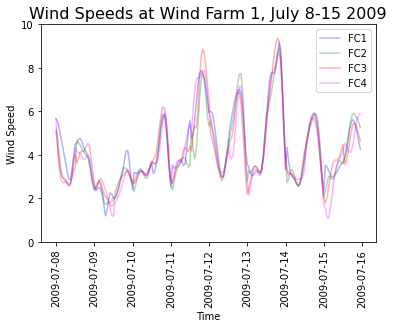

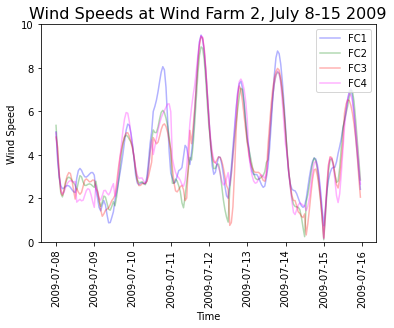

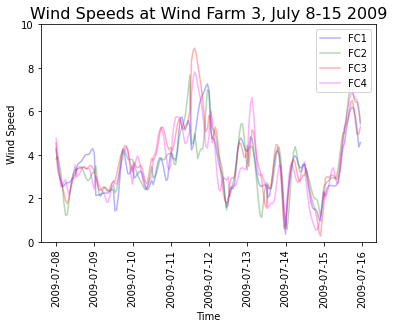

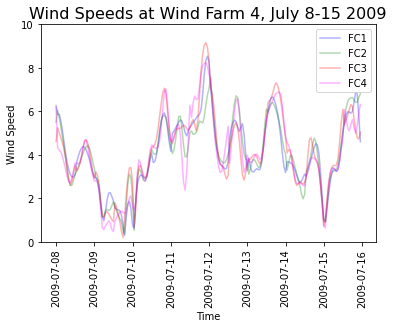

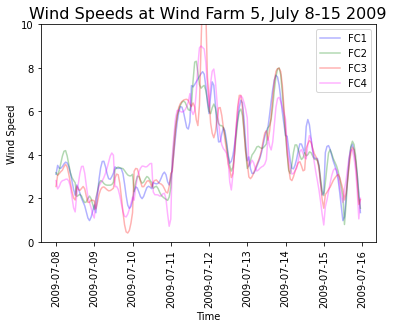

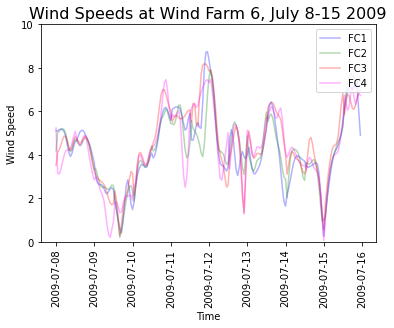

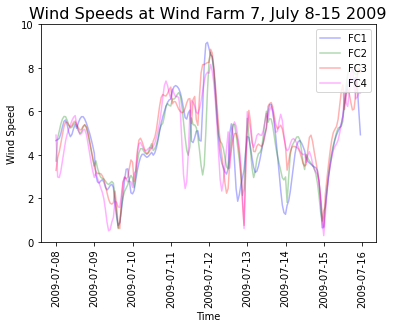

In [14]:
counter = int()
for key, _ in wf_dict.items():
    
    counter += 1
    fc1 = wfn_by_fc(wf_dict[key],1)
    fc2 = wfn_by_fc(wf_dict[key],2)
    fc3 = wfn_by_fc(wf_dict[key],3)
    fc4 = wfn_by_fc(wf_dict[key],4)
    
    plt.figure()
    plt.plot(fc1['ws']['July 8, 2009':'July 15, 2009'], color='blue', label='FC1', alpha=0.3)
    plt.plot(fc2['ws']['July 8, 2009':'July 15, 2009'], color='green', label='FC2', alpha=0.3)
    plt.plot(fc3['ws']['July 8, 2009':'July 15, 2009'], color='red', label='FC3', alpha=0.3)
    plt.plot(fc4['ws']['July 8, 2009':'July 15, 2009'], color='magenta', label='FC4', alpha=0.3)
    plt.legend(loc='upper right') 
    plt.ylim([0,10])
    plt.xlabel('Time')
    plt.xticks(rotation='vertical')
    plt.ylabel('Wind Speed')
    plt.title('Wind Speeds at Wind Farm ' + str(counter) + ', July 8-15 2009', fontsize=16)
    
    plt.show()

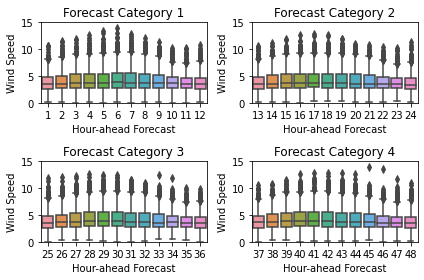

In [15]:

for i in range(1,5):
    plt.subplot(2,2,i)
    sns.boxplot(x='hors', y='ws', data=wfn_by_fc(wf_dict['wf1'],i))
    plt.ylim([0,15])
    plt.title('Forecast Category ' + str(i))
    plt.xlabel('Hour-ahead Forecast')
    plt.ylabel('Wind Speed')

plt.tight_layout()
plt.show()

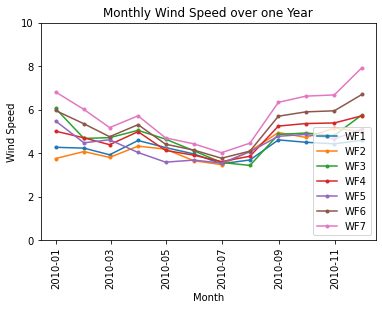

In [16]:
for key, _ in wf_dict.items():
    monthly_ws = wf_dict[key]['ws']['2010'].resample("M",label='left').mean()
    plt.plot(monthly_ws, marker='.')

plt.xlim(['2009-12-15','2010-12-15'])
plt.legend(('WF1', 'WF2', 'WF3', 'WF4', 'WF5', 'WF6', 'WF7'),loc='lower right') 
plt.xlabel('Month')
plt.xticks(rotation='vertical')
plt.title('Monthly Wind Speed over one Year')
plt.ylim([0,10])
plt.ylabel('Wind Speed')
plt.show()

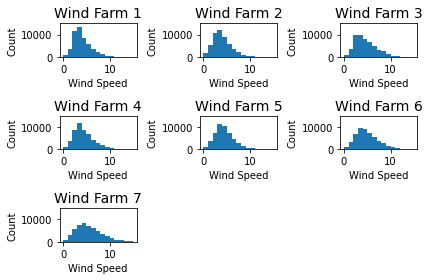

In [18]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    plt.subplot(3,3,counter)
    plt.hist(wf_dict[key]['ws'],bins=15, range=(0,15))
    plt.xlabel('Wind Speed')
    plt.ylabel('Count')
    plt.title('Wind Farm ' + str(counter), fontsize=14)
    plt.ylim(0,15000)
plt.tight_layout()
plt.show()

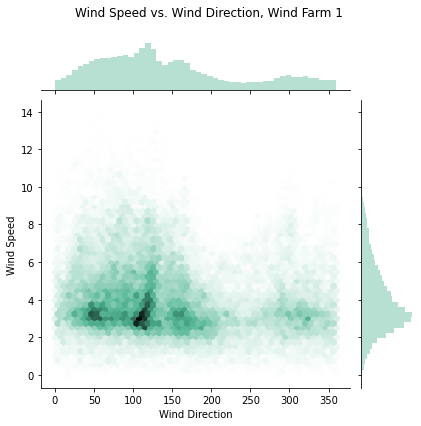

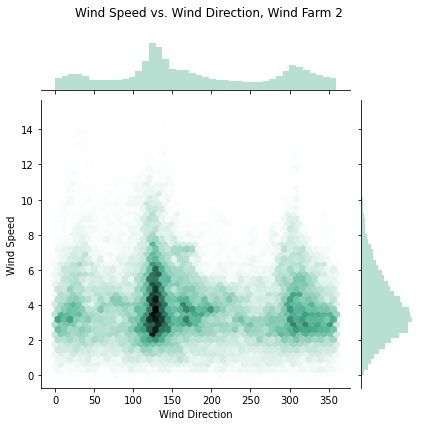

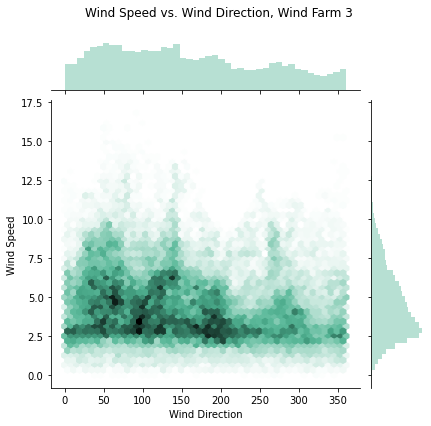

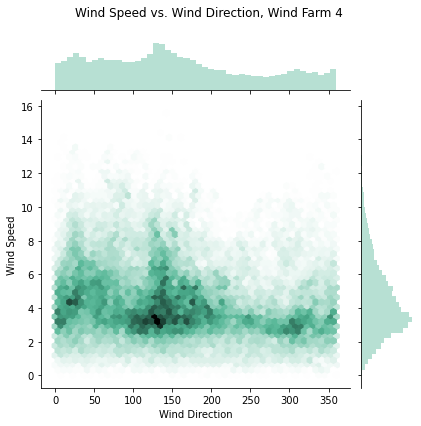

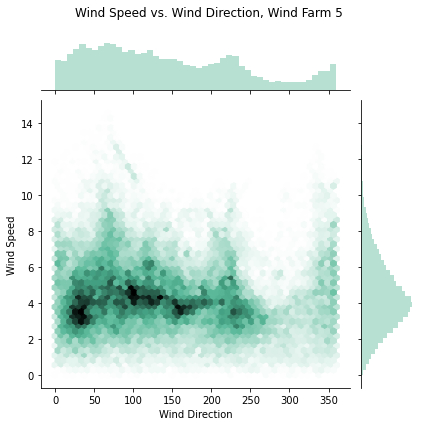

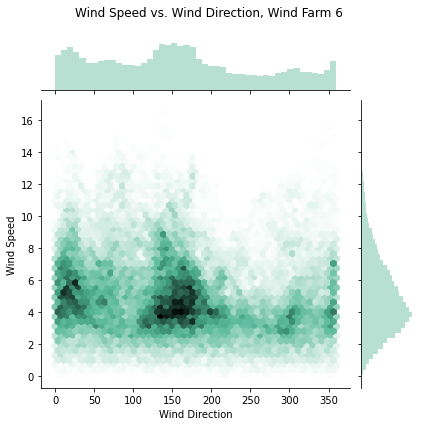

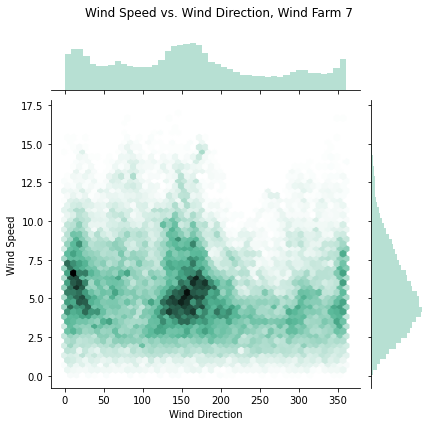

In [19]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    hex = sns.jointplot(x='wd', y='ws', data=wf_dict[key], kind='hex', color="#4CB391").set_axis_labels('Wind Direction', 'Wind Speed')
    hex.fig.subplots_adjust(top=0.9)
    hex.fig.suptitle('Wind Speed vs. Wind Direction, Wind Farm '+ str(counter))
    plt.show()

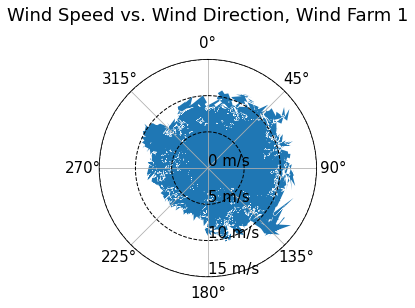

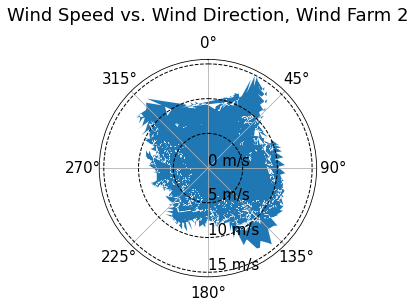

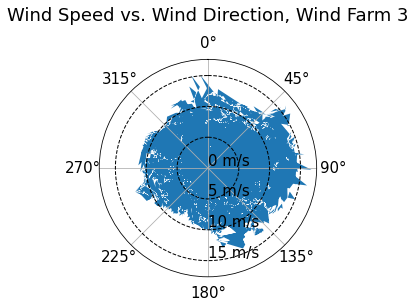

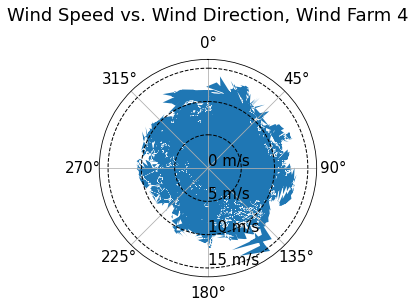

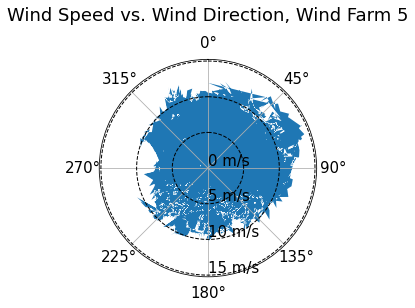

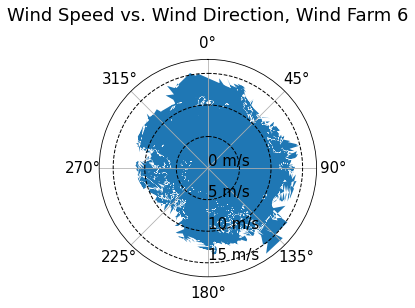

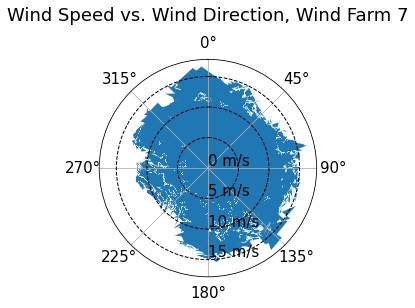

In [20]:

counter = int(0)
for key, _ in wf_dict.items():
    counter +=1 
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.fill_between([np.pi*x/180 for x in wf_dict[key]['wd']], wf_dict[key]['ws'], 0, zorder=0)
    ax.set_rticks([0, 5, 10, 15])  # less radial ticks
    ax.set_rlabel_position(180)  
    ax.tick_params(direction='out', length=6, width=2, colors='k')
    plt.xticks(size=15)
    plt.yticks(size=15)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{} m/s'.format(y) for y in vals])
    ax.grid(True, which='major', axis='y', color="k", linewidth=1, zorder=1, linestyle='--')
    ax.set_title("Wind Speed vs. Wind Direction, Wind Farm " + str(counter), size=18, y=1.15)
    plt.show()

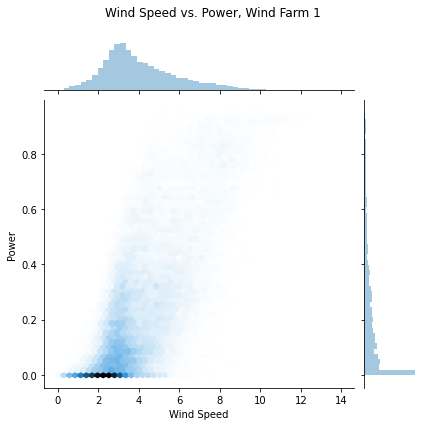

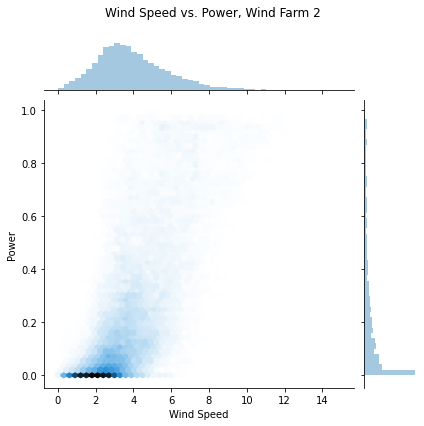

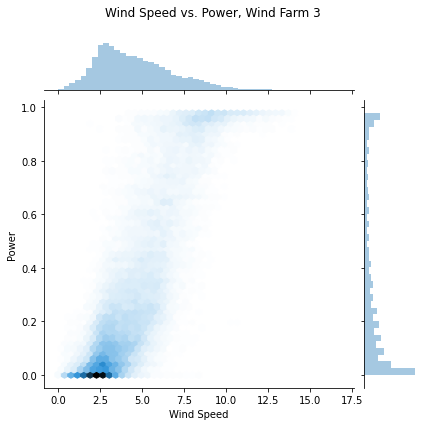

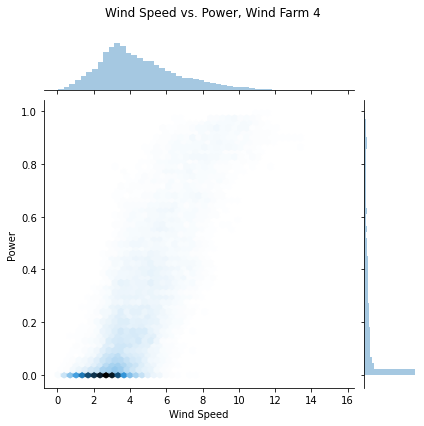

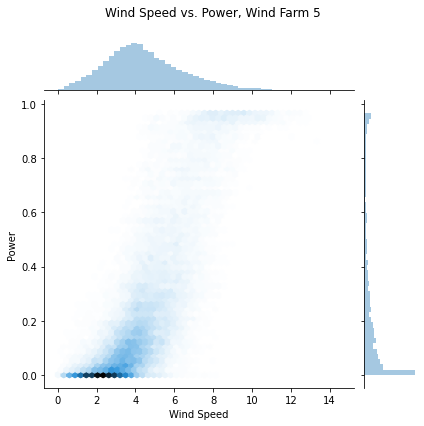

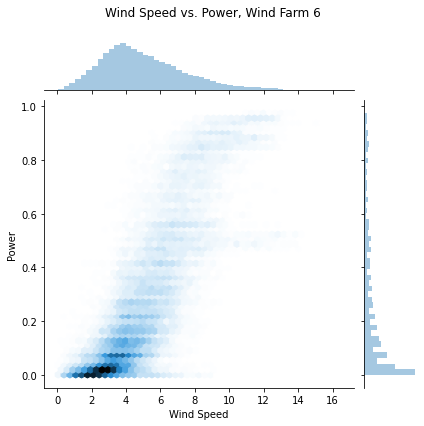

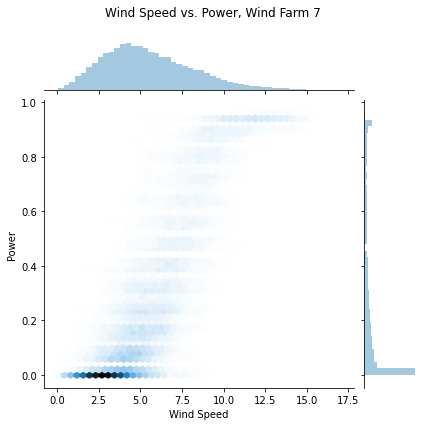

In [21]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    hex = sns.jointplot(x='ws', y=wp_lookup[key], data=wf_dict[key], kind='hex').set_axis_labels('Wind Speed', 'Power')
    hex.fig.subplots_adjust(top=0.9)
    hex.fig.suptitle('Wind Speed vs. Power, Wind Farm ' + str(counter))
plt.show()

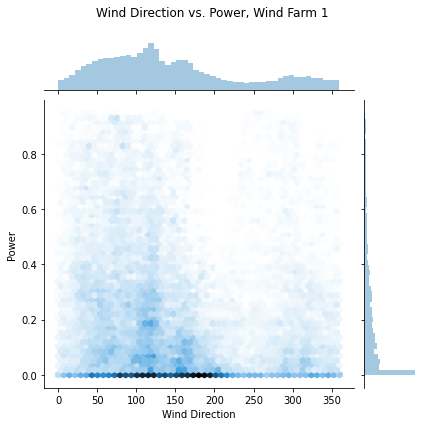

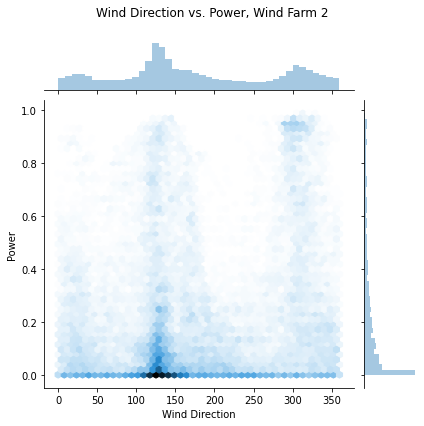

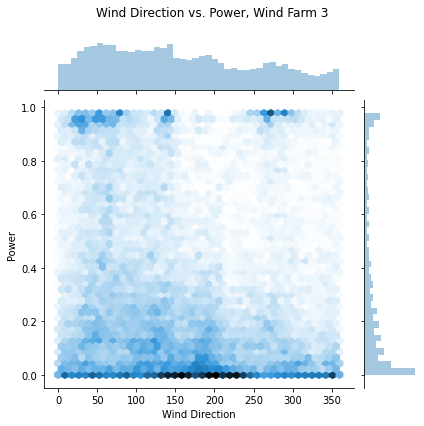

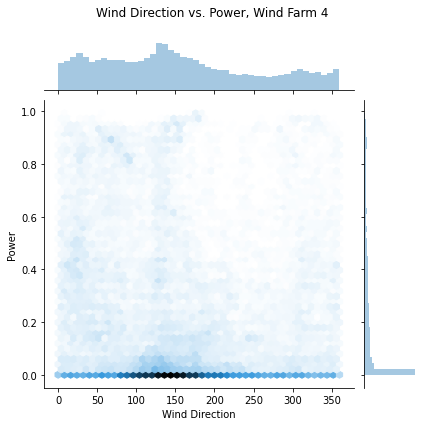

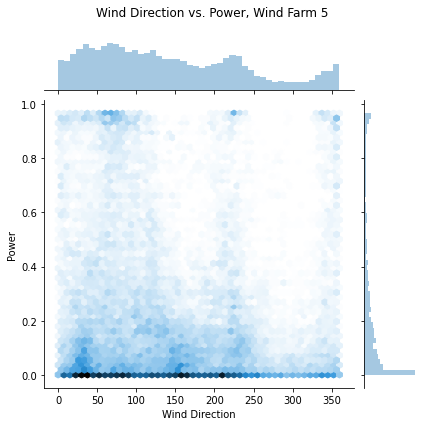

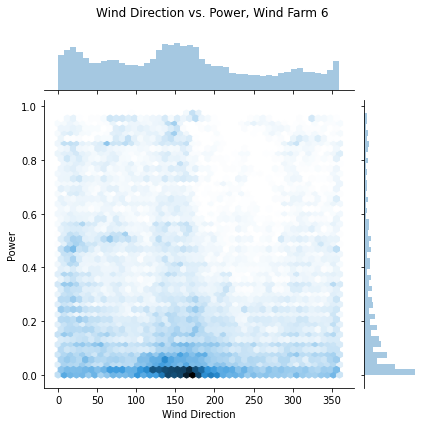

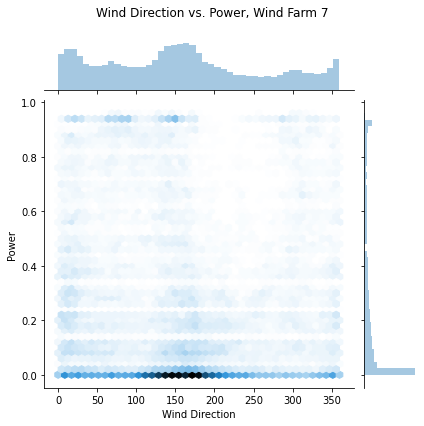

In [22]:
counter = int()
for key, _ in wf_dict.items():
    counter += 1
    hex = sns.jointplot(x='wd', y=wp_lookup[key], data=wf_dict[key], kind='hex').set_axis_labels('Wind Direction', 'Power')
    hex.fig.subplots_adjust(top=0.9)
    hex.fig.suptitle('Wind Direction vs. Power, Wind Farm ' + str(counter))
plt.show()


In [23]:
# Dictionary to hold Z-scores for each wind farm
z_scores = {'wf1':[], 
            'wf2':[],
            'wf3':[],
            'wf4':[],
            'wf5':[],
            'wf6':[],
            'wf7':[]}

for key, _ in wf_dict.items():
    wf = wf_dict[key]
    fc_scores = []  # Empty list of Z Scores
    
    # Compare shorter forecasts to longer forecasts
    for i in [1,2,3]:
            fc_single = wf.loc[(wf['forecast_cat'] == i)]['ws']
            fc_others = wf.loc[(wf['forecast_cat'] > i)]['ws']
            # Sample mean wind speed of single Forecast Category: x_single
            x_single = np.mean(fc_single) 
            # Sample mean wind speed of all other Forecast Categories: x_others
            x_others = np.mean(fc_others)
            # Sample standard deviation wind speed of single Forecast Category: s_single
            s_single = np.std(fc_single)
            # Sample standard deviation wind speed of all other Forecast Categories: s_others
            s_others = np.std(fc_others)
            # Sample size of single Forecast Category: n_single
            n_single = len(fc_single)
            # Sample size of all other Forecast Categories: n_others
            n_others = len(fc_others)
            # Compute Z score
            z = (x_single - x_others) / np.sqrt((s_single**2)/n_single + (s_others**2)/n_others)
            # Add Z score to list of scores
            fc_scores.append(z)
            
    # Compare longer forecasts to shorter forecasts
    for i in [4,3,2]:
            fc_single = wf.loc[(wf['forecast_cat'] == i)]['ws']
            fc_others = wf.loc[(wf['forecast_cat'] < i)]['ws'] 
            # Sample mean wind speed of single Forecast Category: x_single
            x_single = np.mean(fc_single) 
            # Sample mean wind speed of all other Forecast Categories: x_others
            x_others = np.mean(fc_others)
            # Sample standard deviation wind speed of single Forecast Category: s_single
            s_single = np.std(fc_single)
            # Sample standard deviation wind speed of all other Forecast Categories: s_others
            s_others = np.std(fc_others)
            # Sample size of single Forecast Category: n_single
            n_single = len(fc_single)
            # Sample size of all other Forecast Categories: n_others
            n_others = len(fc_others)
            # Compute Z score
            z = (x_single - x_others) / np.sqrt((s_single**2)/n_single + (s_others**2)/n_others)
            # Add Z score to list of scores
            fc_scores.append(z)
    z_scores[key] = fc_scores

z_scores = pd.DataFrame(z_scores) # Convert dictionary to DataFrame
z_scores['fc_comparison'] = ['1v234', '2v34', '3v4', '4v123', '3v12', '2v1']  # List of labels for forecast comparisons 
z_scores.set_index('fc_comparison', inplace=True) # Set indexes to represent forecast comparison
z_scores['avg_z'] = z_scores.mean(axis=1)

print(z_scores)


                    wf1       wf2       wf3  ...       wf6       wf7     avg_z
fc_comparison                                ...                              
1v234          1.798917  2.972729  2.087631  ...  2.321831  2.015196  2.421793
2v34           0.625090  1.699720  0.458644  ...  0.058644 -0.110330  0.703154
3v4            0.136969  0.310422  0.448495  ...  0.639480  0.628765  0.495924
4v123         -1.012907 -2.076900 -1.284078  ... -1.330527 -1.138319 -1.553950
3v12          -1.190827 -2.378989 -1.027465  ... -0.776293 -0.521537 -1.333684
2v1           -1.116845 -1.463473 -1.434667  ... -1.859611 -1.706717 -1.576159

[6 rows x 8 columns]


In [0]:
jon lo